In [1]:
import gc
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tsforest.utils import make_time_range
from mahts import HTSDistributor

# local modules
import sys
sys.path.append("../lib/")
from utils import (compute_scaling, compute_weights, reduce_mem_usage, 
                   compute_scales_by_level, compute_weights_by_level)
from evaluation import _WRMSSEEvaluator, WRMSSEEvaluator, Evaluator, WRMSSEEvaluatorL12
from trend import TrendEstimator, apply_robust_trend_correction

***
## Data loading

In [2]:
data = (pd.read_parquet("../input/train_dataframe.parquet", 
                        columns=["ts_id","item_id", "dept_id", "cat_id", "store_id", 
                                 "state_id", "q", "ds", "no_stock_days", "sell_price"])
        .rename({"q":"y"}, axis=1))

scaling_input = pd.read_parquet("../input/scaling_input.parquet")
weighting_input = pd.read_parquet("../input/weighting_input.parquet")

hierarchy = pd.read_parquet("../input/hierarchy.parquet")
hierarchy_raw = pd.read_parquet("../input/hierarchy_raw.parquet")

In [4]:
forecast = pd.read_csv("../output/forecast-f4-v1.csv", parse_dates=["ds"])
valid_start = forecast.ds.min()
valid_end = forecast.ds.max()
valid_period = (pd.to_datetime(valid_start), pd.to_datetime(valid_end))

In [5]:
%%time
scales_by_level = compute_scales_by_level(scaling_input, valid_period[0])
weights_by_level = compute_weights_by_level(weighting_input, valid_period[0])

CPU times: user 1min 34s, sys: 43.9 s, total: 2min 18s
Wall time: 2min 22s


In [6]:
del scaling_input, weighting_input
gc.collect()

166

In [7]:
ts_id_in_forecast = forecast.merge(hierarchy).ts_id.unique()
valid_data = data.query("@valid_start <= ds <= @valid_end & ts_id in @ts_id_in_forecast")
evaluator = Evaluator(valid_data, weights_by_level, scales_by_level)

In [8]:
infile = open("../input/encoders.pkl", "rb")
encoders = pickle.load(infile)
infile.close()

***
## Original errors

In [9]:
wrmsse = evaluator.eval1._evaluate(valid_data.loc[:, ["ds","item_id","store_id"]].merge(forecast).y_pred.values)
wrmsseL12 = evaluator.eval2._evaluate(valid_data.loc[:, ["ds","item_id","store_id"]].merge(forecast).y_pred.values)
print("wrmsse:", wrmsse)
print("wrmsseL12:", wrmsseL12)
print(evaluator.eval1.errors_by_level)

wrmsse: 0.4867253066395207
wrmsseL12: 0.8160198497354868
{'root': 0.2038058157118851, ('state_id',): 0.30504562660169005, ('store_id',): 0.4165173057089899, ('cat_id',): 0.2694515017179191, ('dept_id',): 0.3625800836371777, ('state_id', 'cat_id'): 0.37073975534892933, ('state_id', 'dept_id'): 0.45550518879214735, ('store_id', 'cat_id'): 0.48355221120618247, ('store_id', 'dept_id'): 0.5666837057444509, ('item_id',): 0.785788043162817, ('item_id', 'state_id'): 0.8050145923065715, ('item_id', 'store_id'): 0.8160198497354868}


***
## Level 1

In [10]:
mrg = pd.merge(data.query("ds <= @valid_end").loc[:, ["ds","item_id","dept_id","cat_id","store_id","state_id","y"]],
               forecast,
               how="left", on=["ds","item_id","store_id"])

In [11]:
mrg_level1 = mrg.groupby(["ds"])[["y","y_pred"]].sum().reset_index()

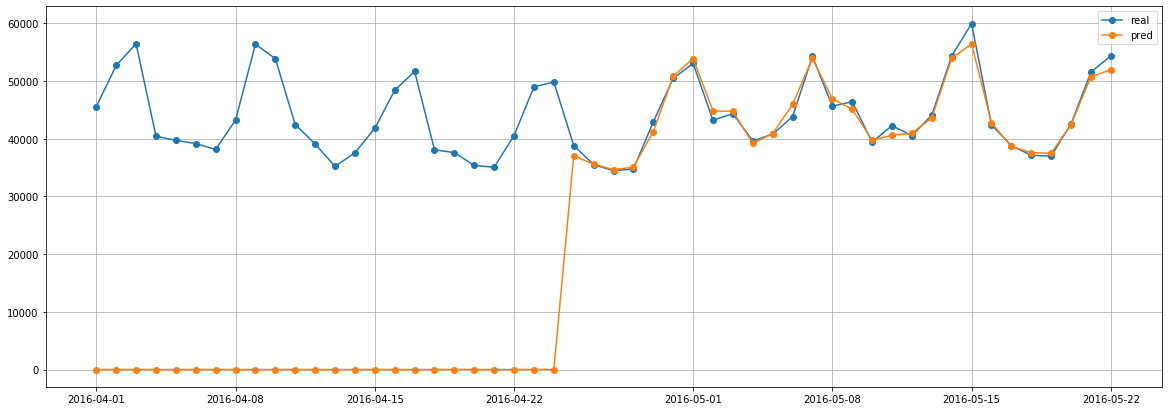

In [12]:
df = mrg_level1.query("ds >= '2016-04-01'")

plt.figure(figsize=(20,7))
plt.plot_date(df.ds, df.y, "o-", label="real")
plt.plot_date(df.ds, df.y_pred, "o-", label="pred")
plt.grid()
plt.legend(loc="best")
plt.show()

In [13]:
predict_data = make_time_range(valid_start, valid_end, "D")

In [14]:
df = pd.concat([
    mrg_level1.query("ds < @valid_start").loc[:, ["ds","y"]],
    mrg_level1.query("ds >= @valid_start").loc[:, ["ds","y_pred"]].rename({"y_pred":"y"}, axis=1)],
    ignore_index=True)

trend_model1 = TrendEstimator(primary_bandwidths=np.arange(40, 47), middle_bandwidth=34, final_bandwidth=15, alpha=5)
trend_model1.fit(df)
trend1 = trend_model1.predict(predict_data)

In [15]:
df = mrg_level1.query("ds < @valid_start").loc[:, ["ds","y"]]

trend_model2 = TrendEstimator(primary_bandwidths=np.arange(109, 119), middle_bandwidth=37, final_bandwidth=31, alpha=10)
trend_model2.fit(df)
trend2 = trend_model2.predict(predict_data)

In [16]:
_mrg_level1 = (mrg_level1
              .merge(trend1, on="ds")
              .merge(trend2, on="ds")
             )
_mrg_level1

,ds,y,y_pred,trend_x,trend_y
0,2016-04-25,38793.0,37048.224637,43246.395034,43075.952397
1,2016-04-26,35487.0,35558.558876,43272.070138,43130.795748
2,2016-04-27,34445.0,34618.673093,43322.450609,43185.639099
3,2016-04-28,34732.0,35055.228721,43383.649432,43240.482450
4,2016-04-29,42896.0,41224.221547,43437.572259,43295.325801
5,2016-04-30,50429.0,50794.980694,43466.637386,43350.169152
6,2016-05-01,53032.0,53861.459158,43495.470663,43405.012502
7,2016-05-02,43181.0,44800.858472,43525.023873,43459.855853
8,2016-05-03,44314.0,44699.894556,43567.249853,43514.699204
9,2016-05-04,39601.0,39187.074543,43642.225255,43569.542555


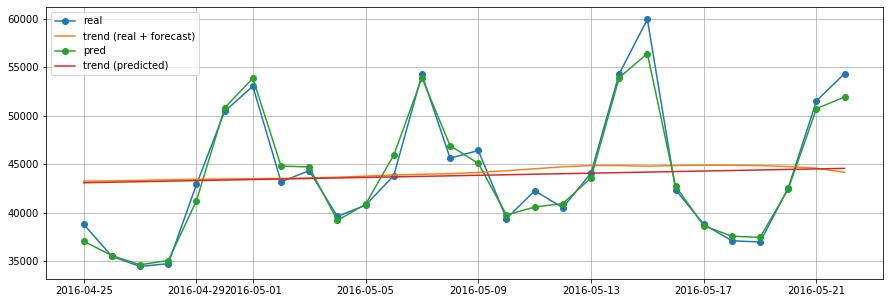

In [17]:
df = _mrg_level1.query("ds >= '2016-04-01'")

plt.figure(figsize=(15,5))
plt.plot_date(df.ds, df.y, "o-", label="real")
plt.plot_date(df.ds, df.trend_x, "-", label="trend (real + forecast)")
plt.plot_date(df.ds, df.y_pred, "o-", label="pred")
plt.plot_date(df.ds, df.trend_y, "-", label="trend (predicted)")
plt.grid()
plt.legend(loc="best")
plt.show()

***
## Level 3

In [18]:
mrg_level3 = mrg.groupby(["ds","store_id"])[["y","y_pred"]].sum().reset_index()

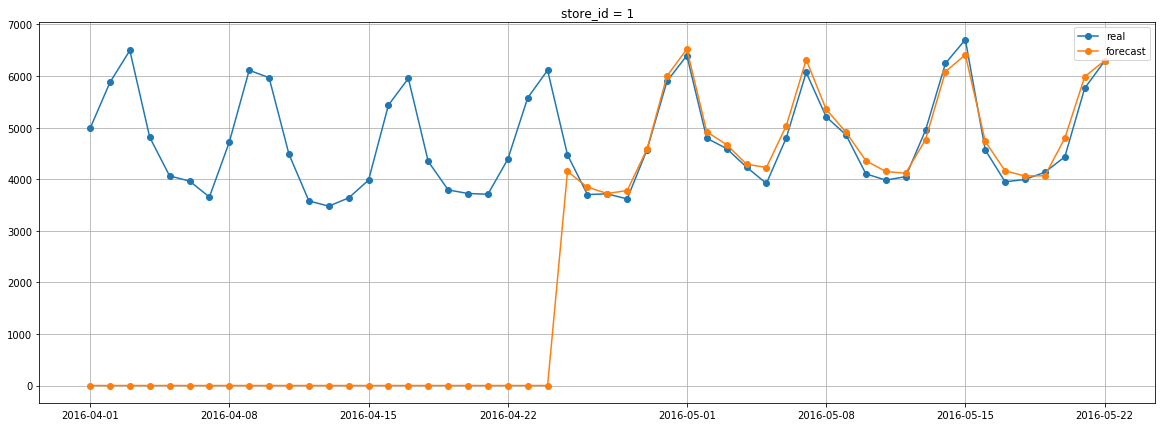

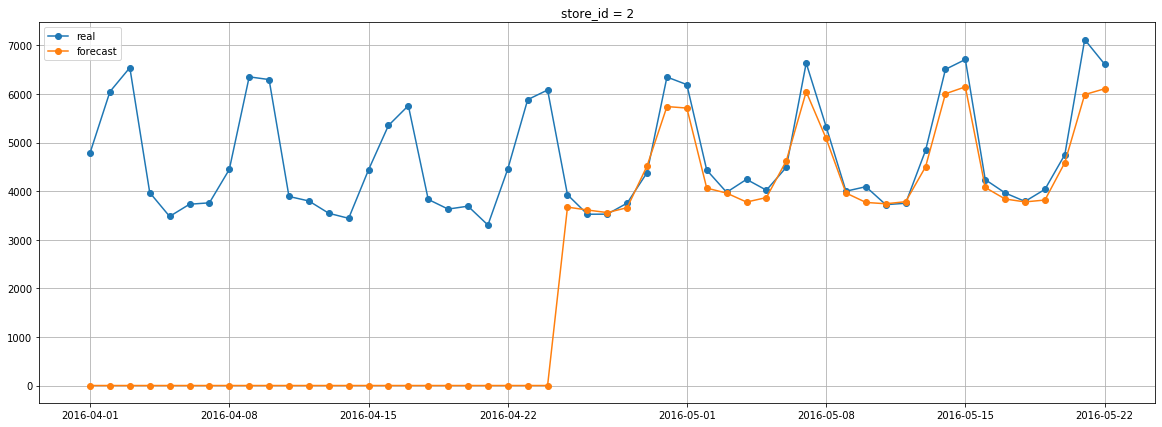

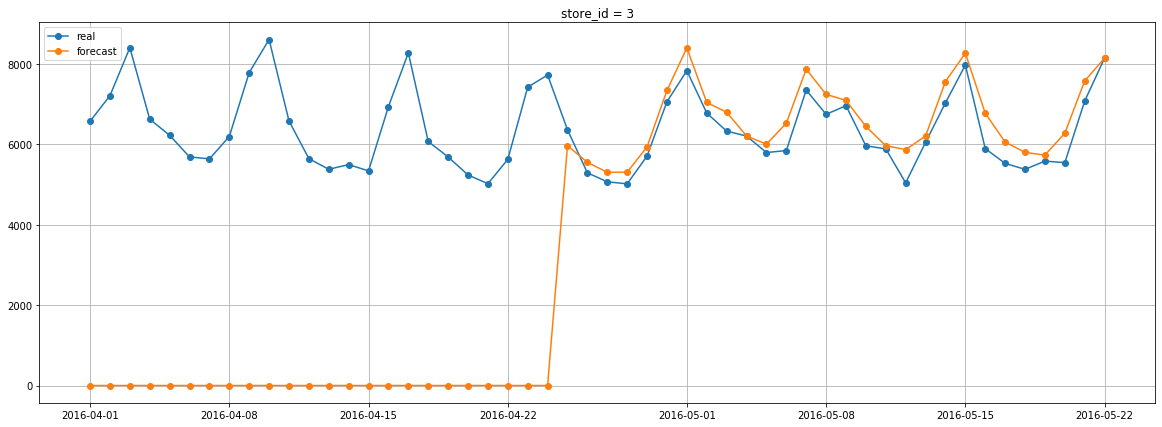

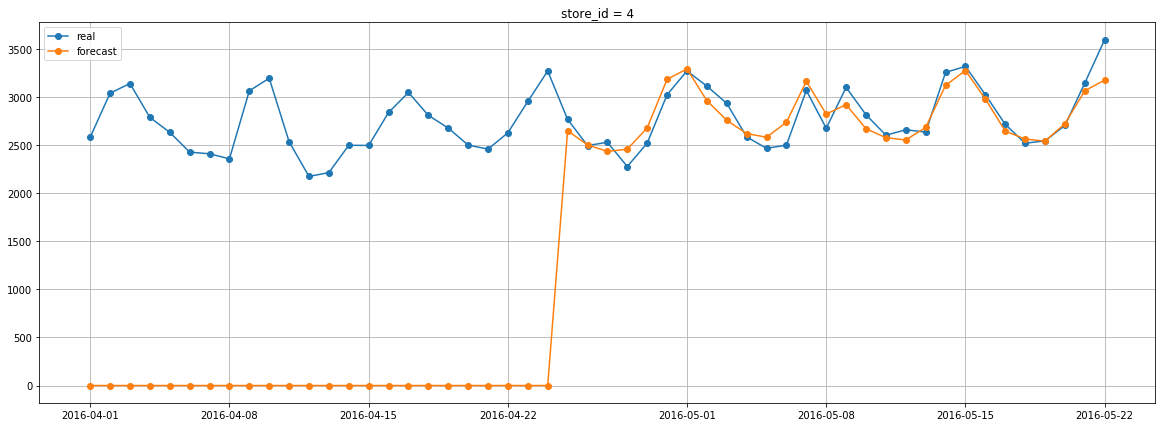

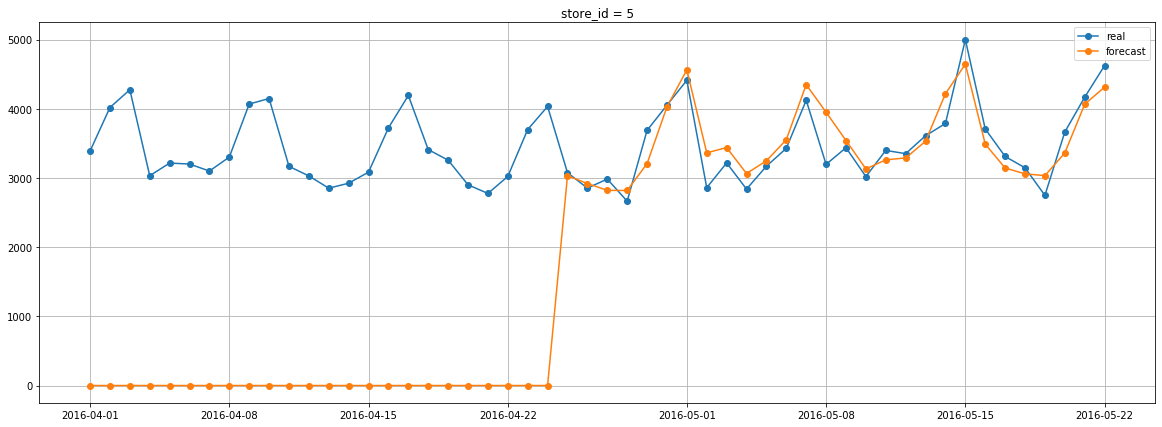

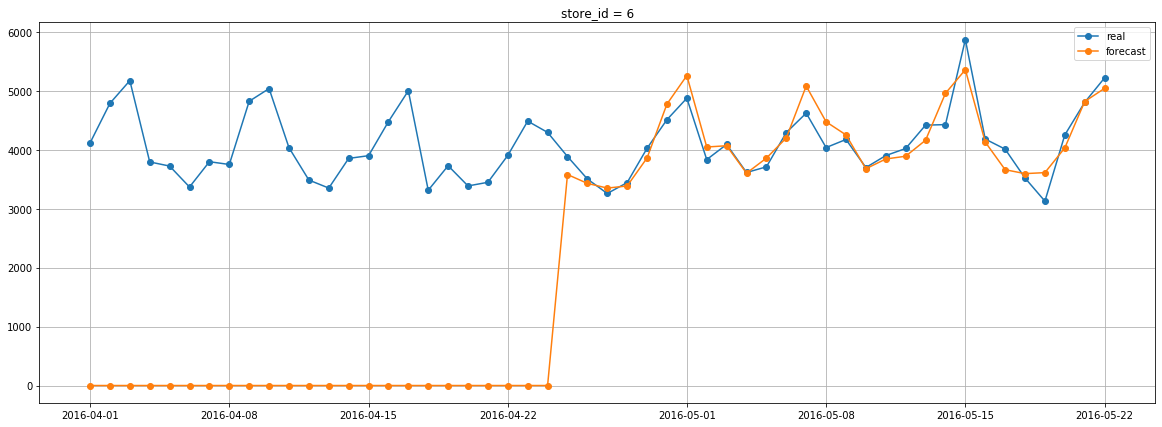

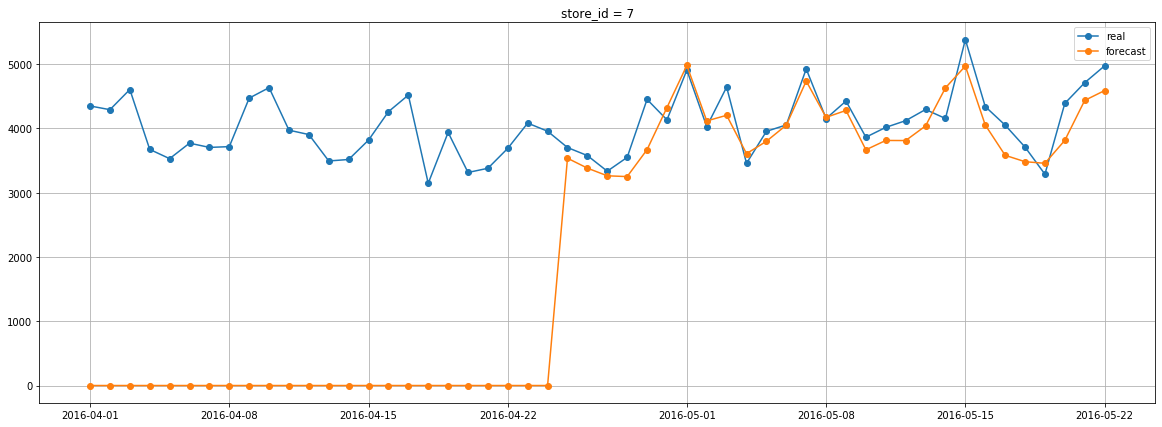

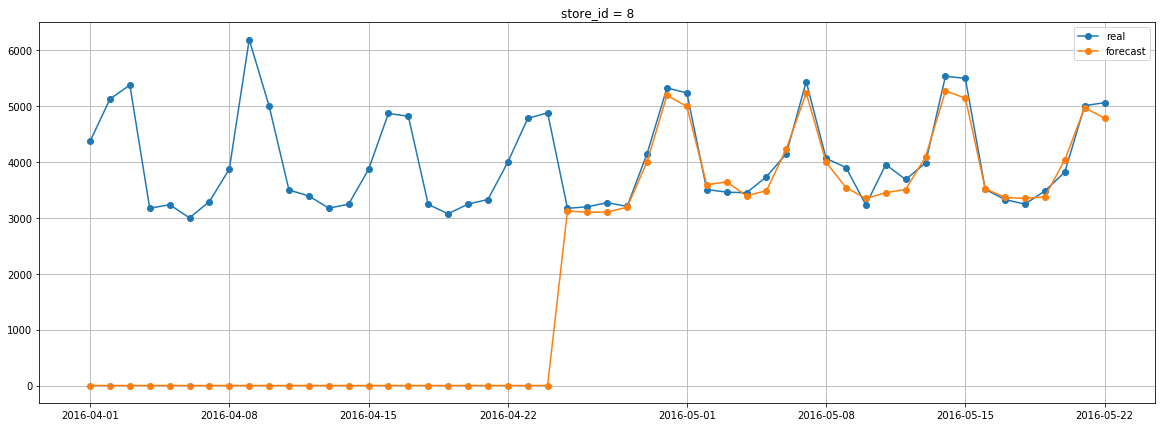

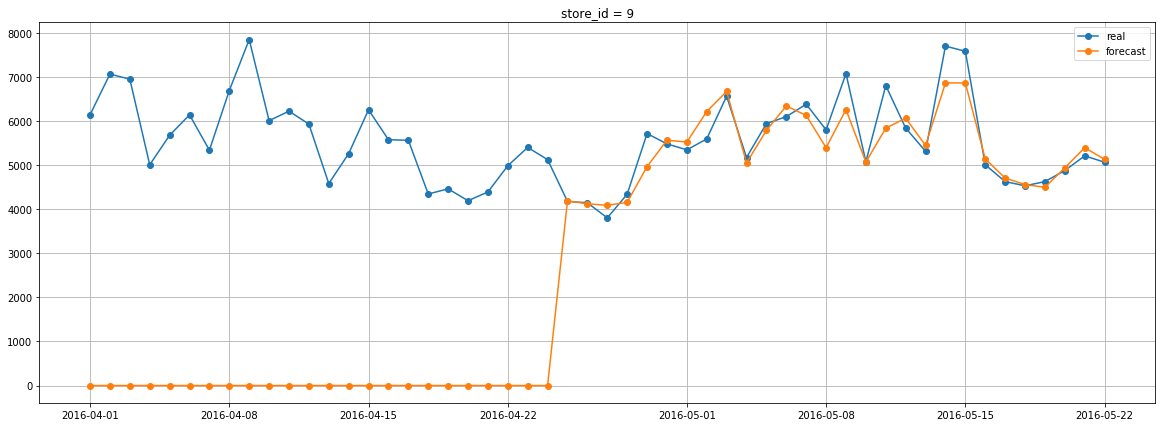

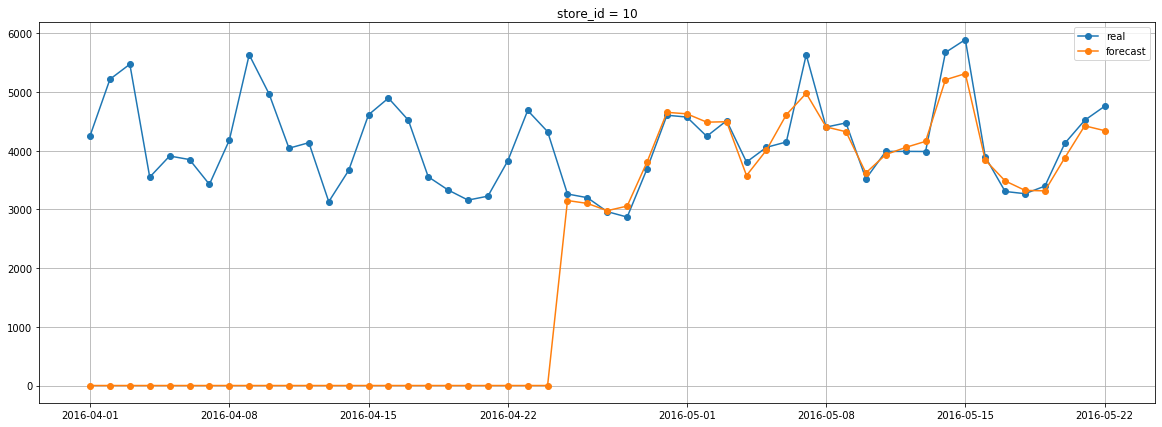

In [19]:
for store_id in mrg_level3.store_id.unique():
    df = mrg_level3.query("store_id == @store_id & ds >= '2016-04-01'")

    plt.figure(figsize=(20,7))
    plt.title(f"store_id = {store_id}")
    plt.plot_date(df.ds, df.y, "o-", label="real")
    plt.plot_date(df.ds, df.y_pred, "o-", label="forecast")
    plt.grid()
    plt.legend(loc="best")
    plt.show()

In [20]:
kwargs1 = {
    "primary_bandwidths": np.arange(32, 56),
    "middle_bandwidth": 19,
    "final_bandwidth": 46,
    "alpha": 6,
    "drop_last_n": 11,
}

kwargs2 = {
    "primary_bandwidths":np.arange(65, 121),
    "middle_bandwidth": 158, 
    "final_bandwidth": 168, 
    "alpha": 10, 
}

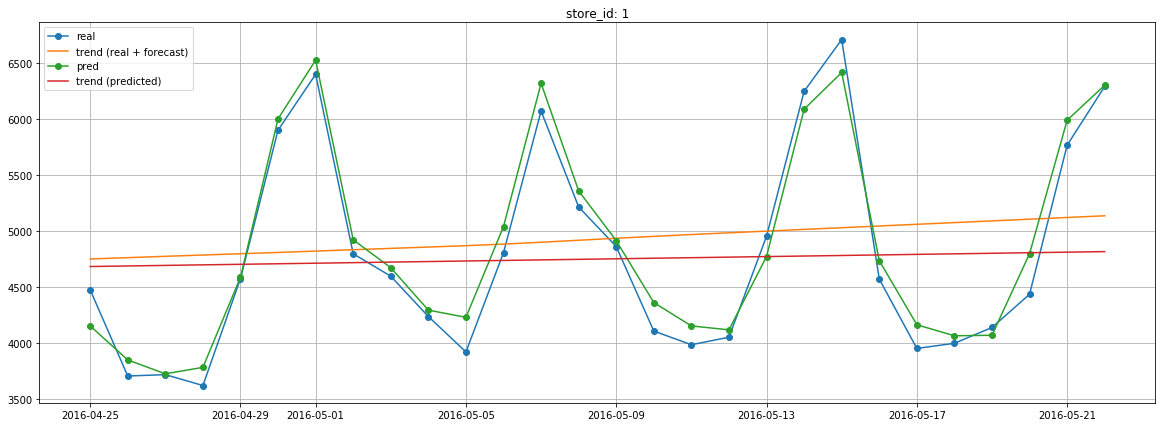

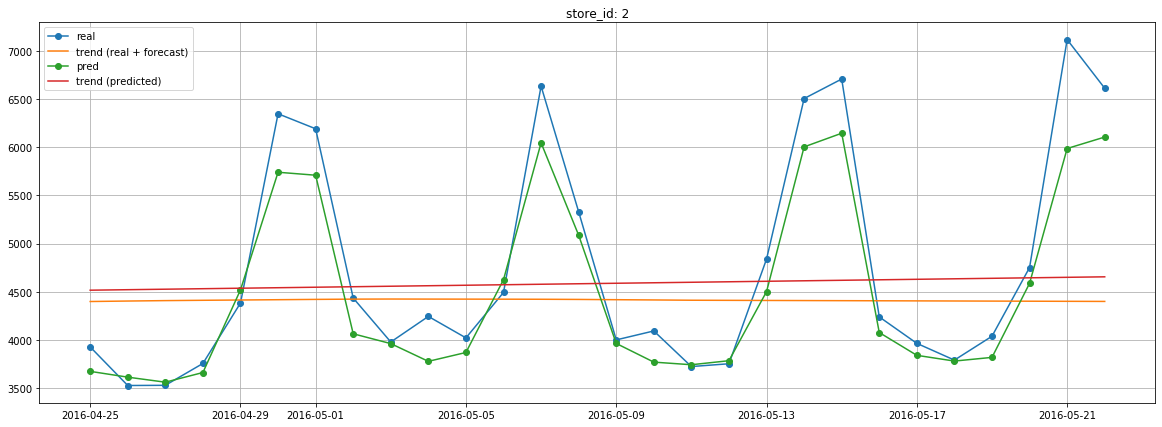

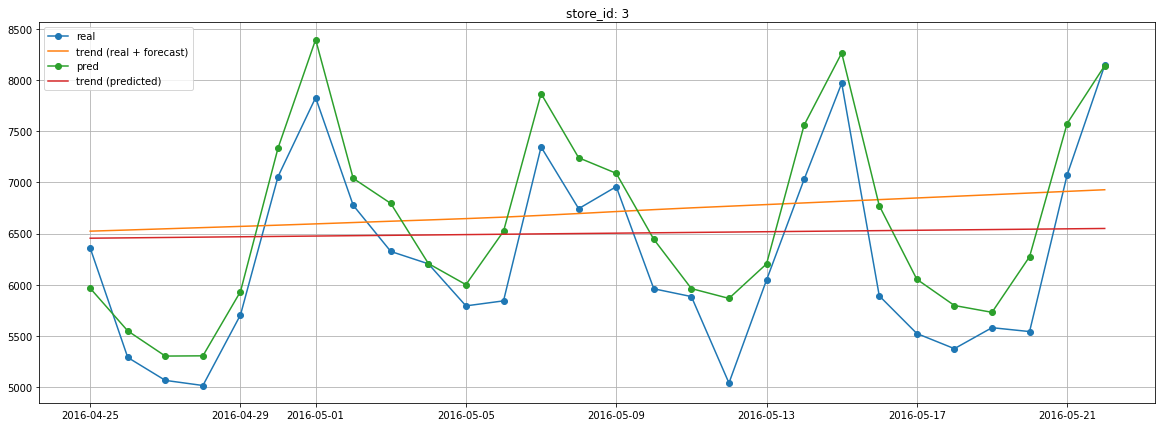

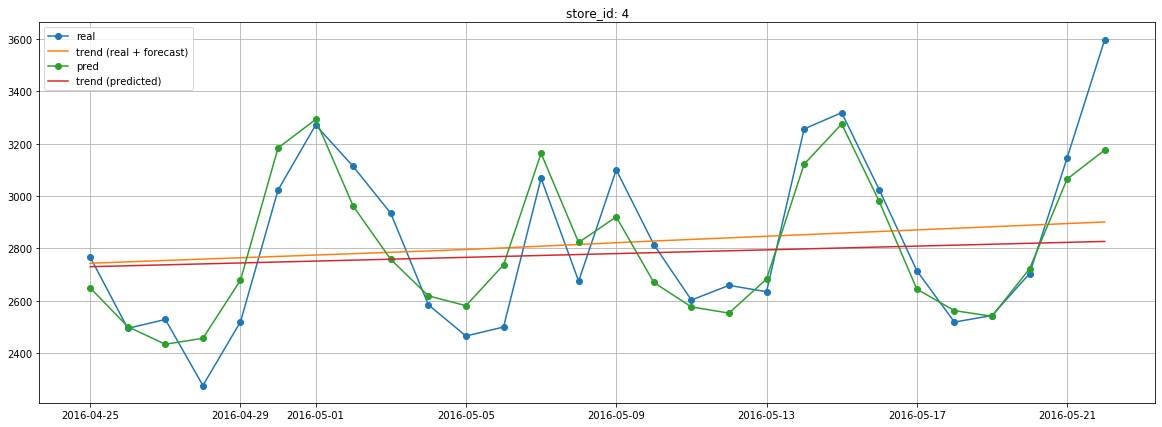

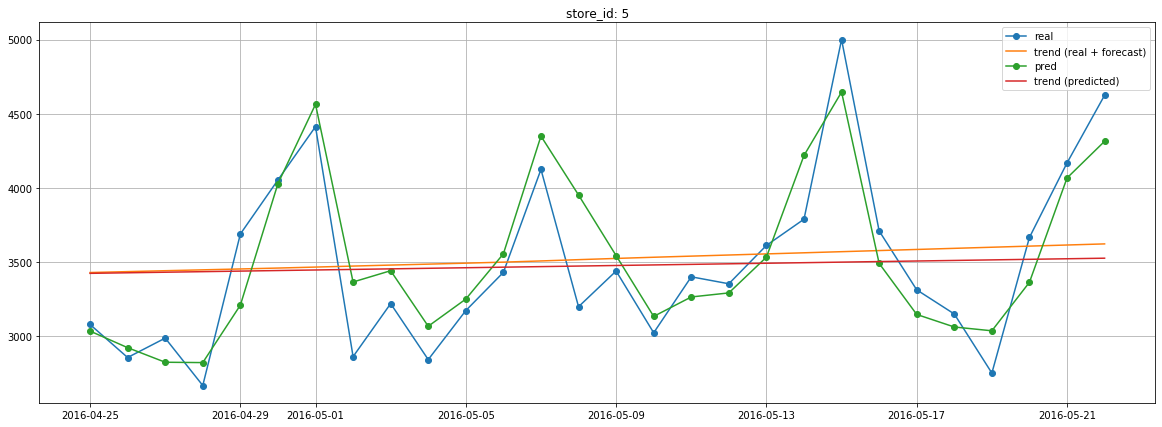

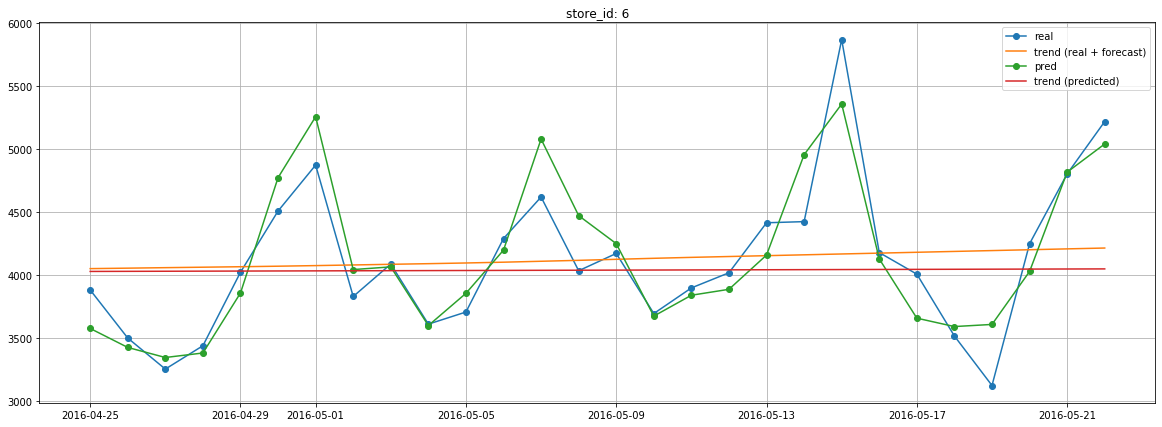

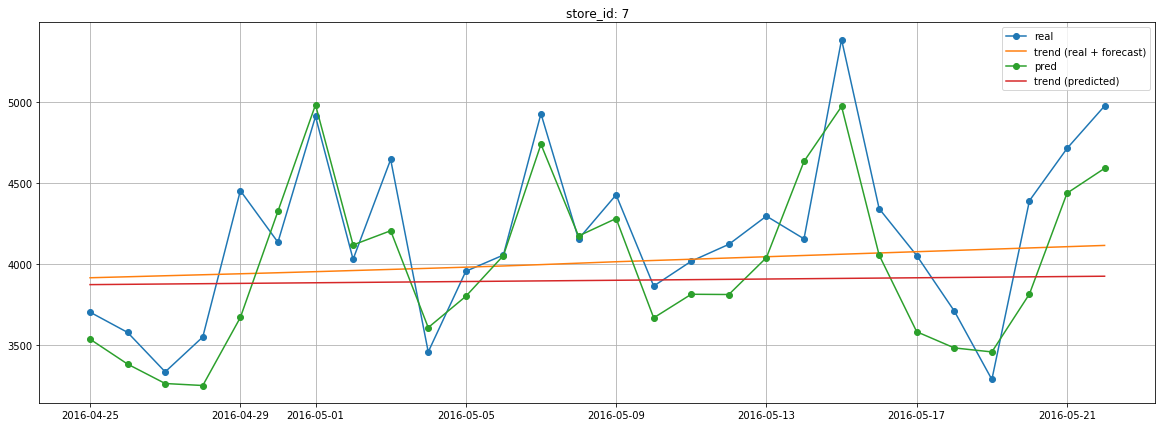

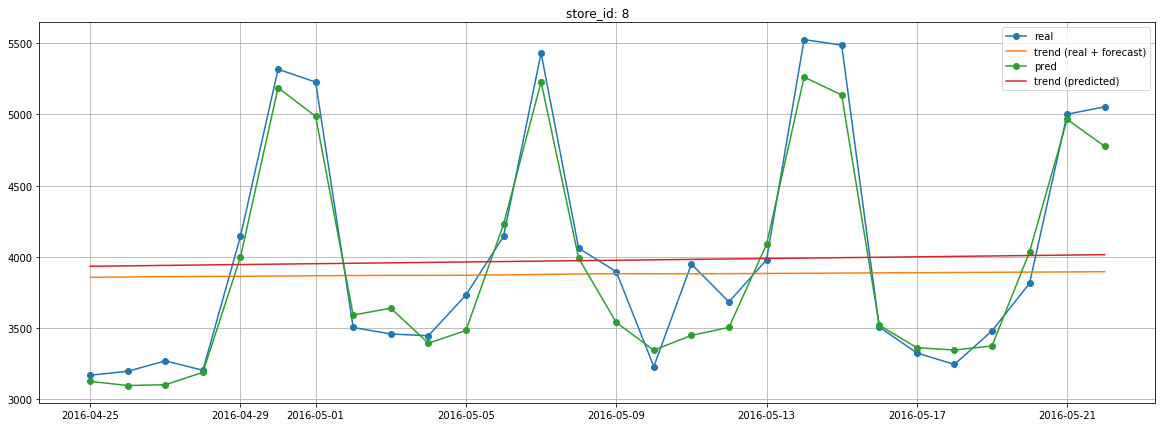

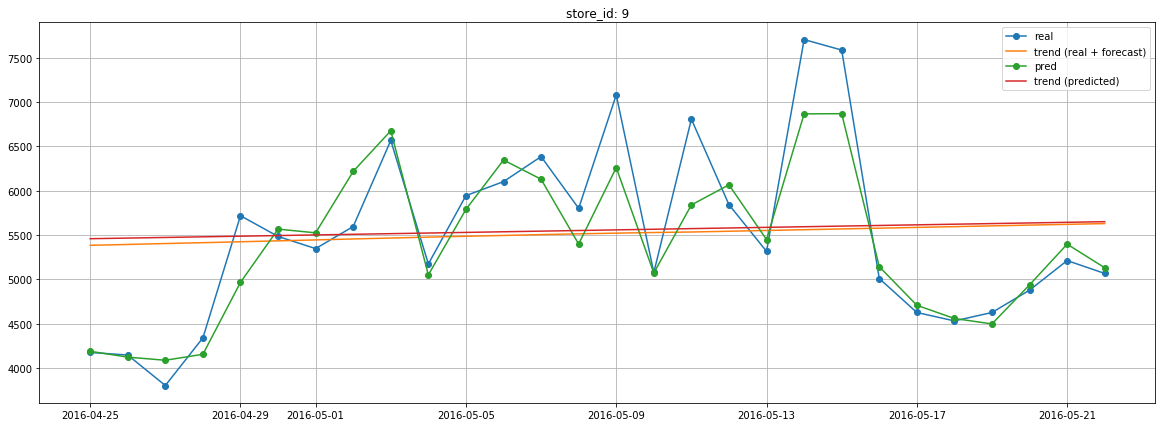

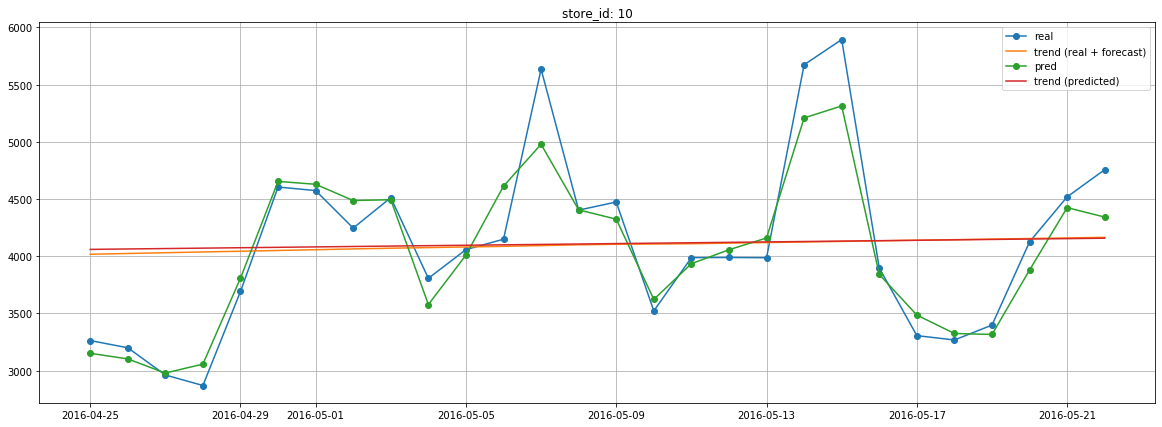

In [21]:
for store_id in mrg_level3.store_id.unique():
    df = pd.concat([
        mrg_level3.query("store_id == @store_id & ds < @valid_start").loc[:, ["ds","y"]],
        mrg_level3.query("store_id == @store_id & ds >= @valid_start").loc[:, ["ds","y_pred"]].rename({"y_pred":"y"}, axis=1)],
        ignore_index=True)

    trend_model1 = TrendEstimator(**kwargs1)
    trend_model1.fit(df)
    trend1 = trend_model1.predict(predict_data)
    
    df = mrg_level3.query("store_id == @store_id & ds < @valid_start").loc[:, ["ds","y"]]

    trend_model2 = TrendEstimator(**kwargs2)
    trend_model2.fit(df)
    trend2 = trend_model2.predict(predict_data)
    
    _mrg_level3 = (mrg_level3.query("store_id == @store_id")
                  .merge(trend1, on="ds")
                  .merge(trend2, on="ds")
                 )
    
    df = _mrg_level3.query("ds >= '2016-04-01'")
    plt.figure(figsize=(20,7))
    plt.title(f"store_id: {store_id}")
    plt.plot_date(df.ds, df.y, "o-", label="real")
    plt.plot_date(df.ds, df.trend_x, "-", label="trend (real + forecast)")
    plt.plot_date(df.ds, df.y_pred, "o-", label="pred")
    plt.plot_date(df.ds, df.trend_y, "-", label="trend (predicted)")
    plt.grid()
    plt.legend(loc="best")
    plt.show()
    

***
## trend corrections

In [22]:
kwargs1 = {
    "primary_bandwidths": np.arange(32, 56),
    "middle_bandwidth": 19,
    "final_bandwidth": 46,
    "alpha": 6,
    "drop_last_n": 11,
}

kwargs2 = {
    "primary_bandwidths":np.arange(65, 121),
    "middle_bandwidth": 158, 
    "final_bandwidth": 168, 
    "alpha": 10, 
}

In [23]:
kwargs_list = [
    ({"primary_bandwidths": np.arange(41, 47),
     "middle_bandwidth": 33,
     "final_bandwidth": 15,
     "alpha": 4,
      "drop_last_n": 0},
     {"primary_bandwidths": np.arange(112, 119),
     "middle_bandwidth": 38,
     "final_bandwidth": 33,
     "alpha": 2}),
    
    ({"primary_bandwidths": np.arange(20, 55),
     "middle_bandwidth": 55,
     "final_bandwidth": 38,
     "alpha": 0,
      "drop_last_n": 1},
     {"primary_bandwidths": np.arange(112, 119),
     "middle_bandwidth": 43,
     "final_bandwidth": 33,
     "alpha": 0}),
        
    ({"primary_bandwidths": np.arange(23, 48),
     "middle_bandwidth": 46,
     "final_bandwidth": 14,
     "alpha": 8,
      "drop_last_n": 1},
     {"primary_bandwidths": np.arange(103, 119),
     "middle_bandwidth": 52,
     "final_bandwidth": 31,
     "alpha": 10}),

    ({"primary_bandwidths": np.arange(16, 30),
     "middle_bandwidth": 39,
     "final_bandwidth": 29,
     "alpha": 5,
      "drop_last_n": 1},
     {"primary_bandwidths": np.arange(107, 116),
     "middle_bandwidth": 156,
     "final_bandwidth": 36,
     "alpha": 0}),
    
]

In [24]:
%%time
#forecast_level3 = apply_trend_correction(data, forecast, level=3, kwargs1=kwargs1, kwargs2=kwargs2)
forecast_level3 = apply_robust_trend_correction(data, forecast, level=3, kwargs_list=kwargs_list)
forecast_level3["store_id"] = encoders["store"].inverse_transform(forecast_level3.store_id)

CPU times: user 8.82 s, sys: 4.5 s, total: 13.3 s
Wall time: 14.3 s


In [25]:
forecast_level1 = forecast_level3.groupby("ds")["y_pred"].sum().reset_index().set_index("ds").rename({"y_pred":"root"}, axis=1)

In [26]:
forecast_level3 = forecast_level3.pivot(index="ds", columns="store_id", values="y_pred")

In [27]:
forecast = forecast.merge(hierarchy.loc[:, ["id","item_id","store_id"]], how="left")
forecast_level12 = forecast.pivot(index="ds", columns="id", values="y_pred")

In [28]:
forecast_concat = pd.concat([forecast_level1, forecast_level3, forecast_level12], axis=1)
forecast_concat.head()

,root,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,...,HOUSEHOLD_2_516_CA_1,HOUSEHOLD_2_516_CA_2,HOUSEHOLD_2_516_CA_3,HOUSEHOLD_2_516_CA_4,HOUSEHOLD_2_516_TX_1,HOUSEHOLD_2_516_TX_2,HOUSEHOLD_2_516_TX_3,HOUSEHOLD_2_516_WI_1,HOUSEHOLD_2_516_WI_2,HOUSEHOLD_2_516_WI_3
ds,,,,,,,,,,,,,,,,,,,,,
2016-04-25,36962.575871,4112.359119,3772.806291,5841.138745,2634.482546,3045.539374,3495.981589,3500.883829,3178.064813,4206.202439,...,0.140967,0.191546,0.108295,0.078851,0.091851,0.259675,0.110169,0.077405,0.00000,0.054833
2016-04-26,35482.313910,3805.043790,3719.402385,5416.946766,2484.696436,2934.052752,3339.475513,3345.050779,3151.216469,4155.967123,...,0.154282,0.213523,0.143236,0.083350,0.110739,0.242960,0.153754,0.080055,0.00000,0.093242
2016-04-27,34550.210832,3677.987015,3673.525046,5162.839861,2415.408850,2835.778403,3253.279068,3223.339438,3157.096142,4138.713924,...,0.164267,0.209069,0.142560,0.092757,0.113034,0.242876,0.163470,0.082914,0.00000,0.097616
2016-04-28,34980.234923,3729.477126,3777.653971,5153.813741,2435.755402,2831.644047,3281.029129,3209.184511,3243.309861,4222.865298,...,0.163988,0.214884,0.156600,0.092473,0.130623,0.252302,0.153388,0.097109,0.00000,0.102918
2016-04-29,41141.525435,4527.962713,4640.203668,5769.640356,2654.627727,3217.798491,3747.022047,3626.202365,4054.188642,5049.451143,...,0.227960,0.305721,0.191462,0.104389,0.151835,0.326054,0.195897,0.128503,0.05422,0.125876


In [29]:
%%time
hierarchy_dict = {"root":hierarchy_raw.store_id.unique()}

ts_id_in_forecast = forecast.id.unique()
for store_id in hierarchy_raw.store_id.unique():
    hierarchy_dict[store_id] = hierarchy_raw.query("store_id == @store_id & id in @ts_id_in_forecast").id.unique()

hts = HTSDistributor(hierarchy_dict)

CPU times: user 3min 44s, sys: 32.3 s, total: 4min 16s
Wall time: 4min 25s


In [30]:
%%time
fcst_reconc = hts.compute_forecast_proportions(forecast_concat)

CPU times: user 12.3 s, sys: 10.6 s, total: 22.8 s
Wall time: 15.6 s


In [31]:
fcst_reconc.set_index(forecast_concat.index, inplace=True)
fcst_reconc = fcst_reconc.loc[:, hts.bottom_nodes].transpose()
forecast_reconc = (
    fcst_reconc
    .reset_index()
    .rename({"index":"id"}, axis=1)
    .melt(id_vars="id", 
          value_vars=[valid_start+pd.DateOffset(days=i) for i in range(28)],
          value_name="y_pred")
              )
forecast_reconc["id"] = encoders["id"].transform(forecast_reconc.id)

In [32]:
# proportions
_mrg = pd.merge(valid_data.loc[:, ["ds","ts_id","y"]], forecast_reconc, how="inner", left_on=["ds","ts_id"], right_on=["ds","id"])
wrmsse = evaluator.eval1._evaluate(_mrg.y_pred.values)
wrmsseL12 = evaluator.eval2._evaluate(_mrg.y_pred.values)
print("wrmsse:", wrmsse)
print("wrmsseL12:", wrmsseL12)
print(evaluator.eval1.errors_by_level)

wrmsse: 0.48245283553996215
wrmsseL12: 0.8163525706947394
{'root': 0.21336574540611838, ('state_id',): 0.3121564663477048, ('store_id',): 0.3883275423305498, ('cat_id',): 0.2715743868372279, ('dept_id',): 0.36130389548529346, ('state_id', 'cat_id'): 0.37486520565713766, ('state_id', 'dept_id'): 0.45568893351243356, ('store_id', 'cat_id'): 0.4576141927887281, ('store_id', 'dept_id'): 0.5453850842419689, ('item_id',): 0.7864568354562427, ('item_id', 'state_id'): 0.8063431677214008, ('item_id', 'store_id'): 0.8163525706947394}


In [34]:
# lsmr
_mrg = pd.merge(valid_data.loc[:, ["ds","ts_id","y"]], forecast_reconc, how="inner", left_on=["ds","ts_id"], right_on=["ds","id"])
wrmsse = evaluator.eval1._evaluate(_mrg.y_pred.values)
wrmsseL12 = evaluator.eval2._evaluate(_mrg.y_pred.values)
print("wrmsse:", wrmsse)
print("wrmsseL12:", wrmsseL12)
print(evaluator.eval1.errors_by_level)

wrmsse: 0.49076756019403306
wrmsseL12: 0.8162352869120937
{'root': 0.22307555432275736, ('state_id',): 0.3221825323118399, ('store_id',): 0.39484199311311113, ('cat_id',): 0.27345836185230604, ('dept_id',): 0.36725419455485986, ('state_id', 'cat_id'): 0.38873814304895343, ('state_id', 'dept_id'): 0.47555112015544937, ('store_id', 'cat_id'): 0.46895697351576876, ('store_id', 'dept_id'): 0.5668176936721694, ('item_id',): 0.7860172348920105, ('item_id', 'state_id'): 0.8060816339770767, ('item_id', 'store_id'): 0.8162352869120937}


***